In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import yaml

In [2]:
%run ./src/database.py
%run ./src/util.py
%run ./src/feature_engineering.py

In [3]:
YAML_FILEPATHNAME = "./config.yaml"
PRE_CRUISE_DB = 0
POST_CRUISE_DB = 1

In [4]:
# Read YAML file
yaml_data = read_yaml(YAML_FILEPATHNAME)

# Preprocessing

In [5]:
DATA_PATH = yaml_data['data_path']
TEST_SIZE = yaml_data['test_size']
RANDOM_STATE = yaml_data['random_state']
TARGET_VARIABLE = yaml_data['target_variable']

In [6]:
# Read source data (Pre_cruise, Post_cruise) with removal of duplicates
ds_pre_cruise = Database(DATA_PATH)
df_pre_cruise = ds_pre_cruise.db_read(yaml_data['databases'][PRE_CRUISE_DB])

ds_post_cruise = Database(DATA_PATH)
df_post_cruise = ds_post_cruise.db_read(yaml_data['databases'][POST_CRUISE_DB])

In [7]:
# Merge Pre_cruise and Post_cruise to form df_cruise with Index as the key
df_cruise = merge_dataframe (df_pre_cruise, df_post_cruise)

In [8]:
# Split composite field to increase interpretability
split_column(df_cruise, 'Source of Traffic', ['Source', 'Traffic'], ' - ')

split_column(df_cruise, 'Cruise Distance', ['Distance', 'Dist_Metrics'], ' ')
df_cruise['Distance'] = pd.to_numeric(df_cruise['Distance'], errors='coerce').astype('float')

In [9]:
# Split composite field to increase interpretability
convert_object_to_datetime (df_cruise, ['Date of Birth'],['%d/%m/%Y'])
convert_object_to_datetime (df_cruise, ['Logging'],['%d/%m/%Y %H:%M'])

In [10]:
# Removal of rows which has missing value 
remove_missing_value(df_cruise,['Date of Birth', TARGET_VARIABLE, 'Distance','Logging'])

In [11]:
df_cruise[['Distance']].head()

,Distance
index,
2,1167.0
3,280.0
4,1145.0
6,607.0
10,594.0


In [12]:
# Label encode non-numeric categorical columns to get numeric values
list_non_numeric_col = ['Gender','Onboard Wifi Service','Onboard Dining Service','Onboard Entertainment','Cruise Name',
                            'Ticket Type','Source','Traffic','Dist_Metrics']
label_encoder(df_cruise,list_non_numeric_col)

In [13]:
# Derive year from date column to enhance model efficiency, mitigate noise
convert_datetime_to_year(df_cruise, ['Date of Birth','Logging'],['Year of Birth','Year of Logging'])

In [14]:
# Remove IDs columns as in general they will have no predictive power
remove_col(df_cruise,['Ext_Intcode_x', 'Ext_Intcode_y'])

# Feature Engineering

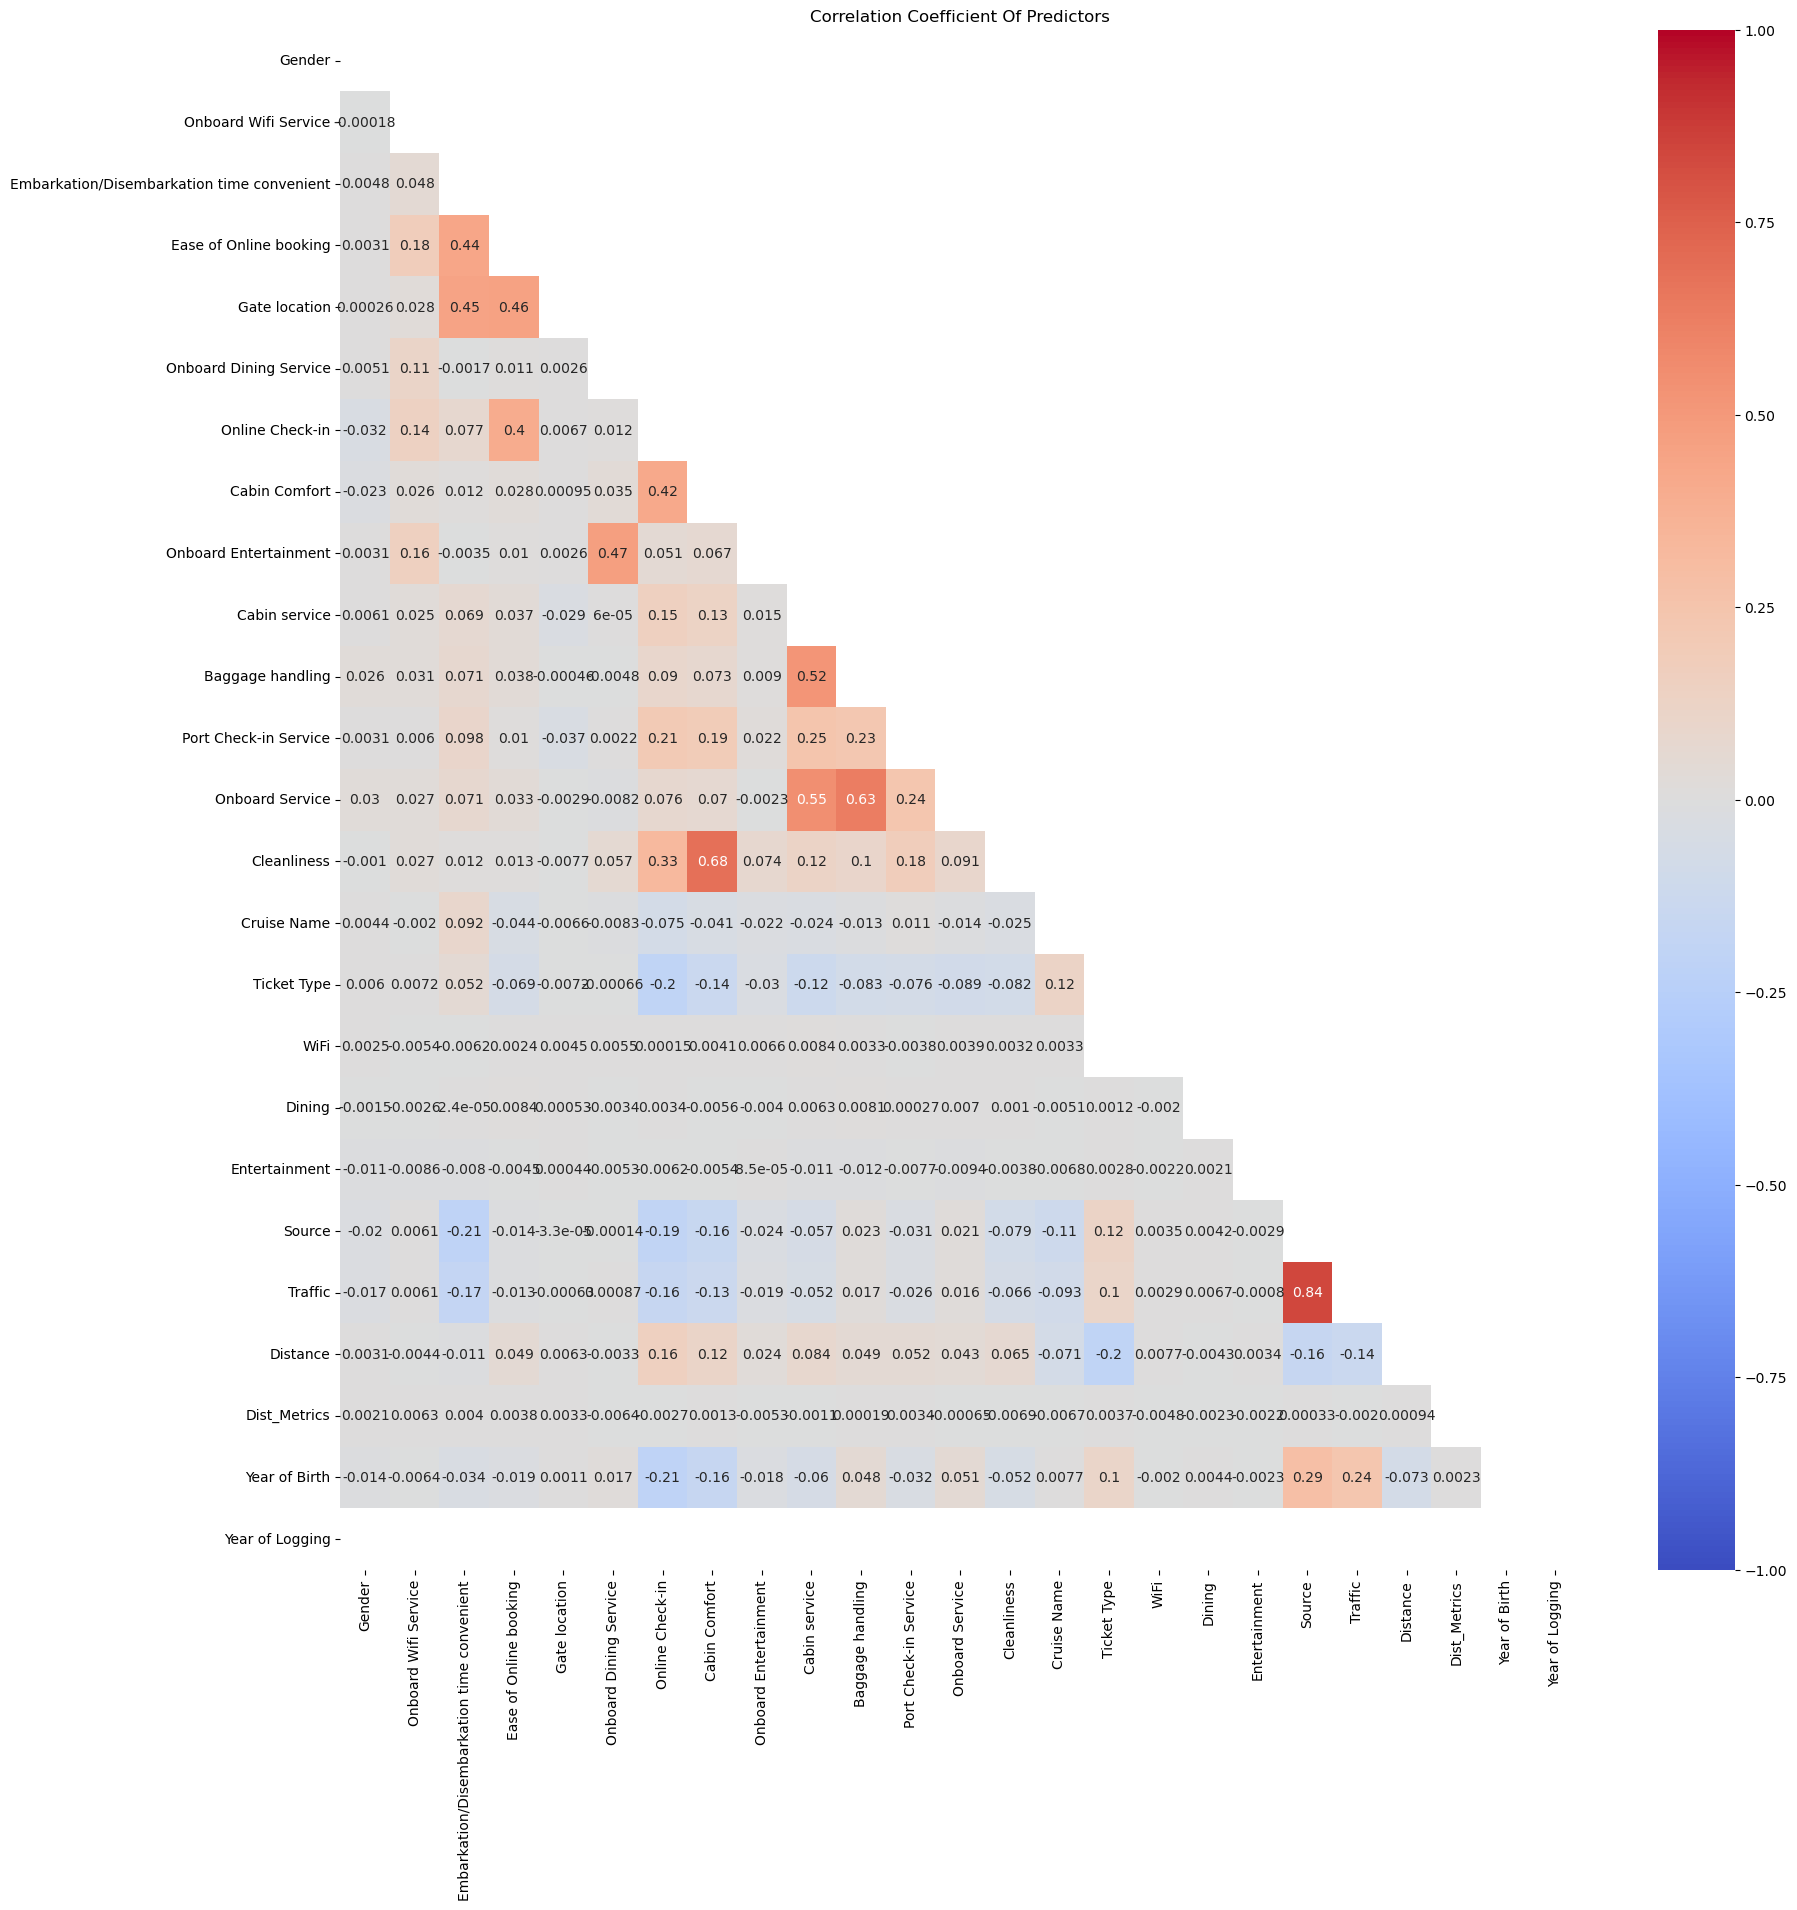

In [16]:
plot_corr_chart(df_cruise)

In [17]:
df_cruise.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84459 entries, 2 to 133745
Data columns (total 25 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Gender                                      84459 non-null  int32  
 1   Onboard Wifi Service                        84459 non-null  int32  
 2   Embarkation/Disembarkation time convenient  74625 non-null  float64
 3   Ease of Online booking                      72801 non-null  float64
 4   Gate location                               73566 non-null  float64
 5   Onboard Dining Service                      84459 non-null  int32  
 6   Online Check-in                             74523 non-null  float64
 7   Cabin Comfort                               71644 non-null  float64
 8   Onboard Entertainment                       84459 non-null  int32  
 9   Cabin service                               75731 non-null  float64
 10  Baggage handli

In [18]:
%run ./src/feature_engineering.py
# Standardise distance by converting Mile to KM
convert_miles_to_KM(df_cruise, "Distance")

In [19]:
df_cruise[['Year of Logging', 'Year of Birth']]

,Year of Logging,Year of Birth
index,,
2,2023,1998
3,2023,1970
4,2023,1960
6,2023,1986
10,2023,2008
...,...,...
133731,2023,1958
133734,2023,1979
133739,2023,1962


In [20]:
# Derive Age from Year of Birth and Year of Logging
calc_year_diff(df_cruise, 'Year of Logging', 'Year of Birth', 'Age')

In [21]:
# Impute Missing Value in dataframe
impute_missing_value(df_cruise)

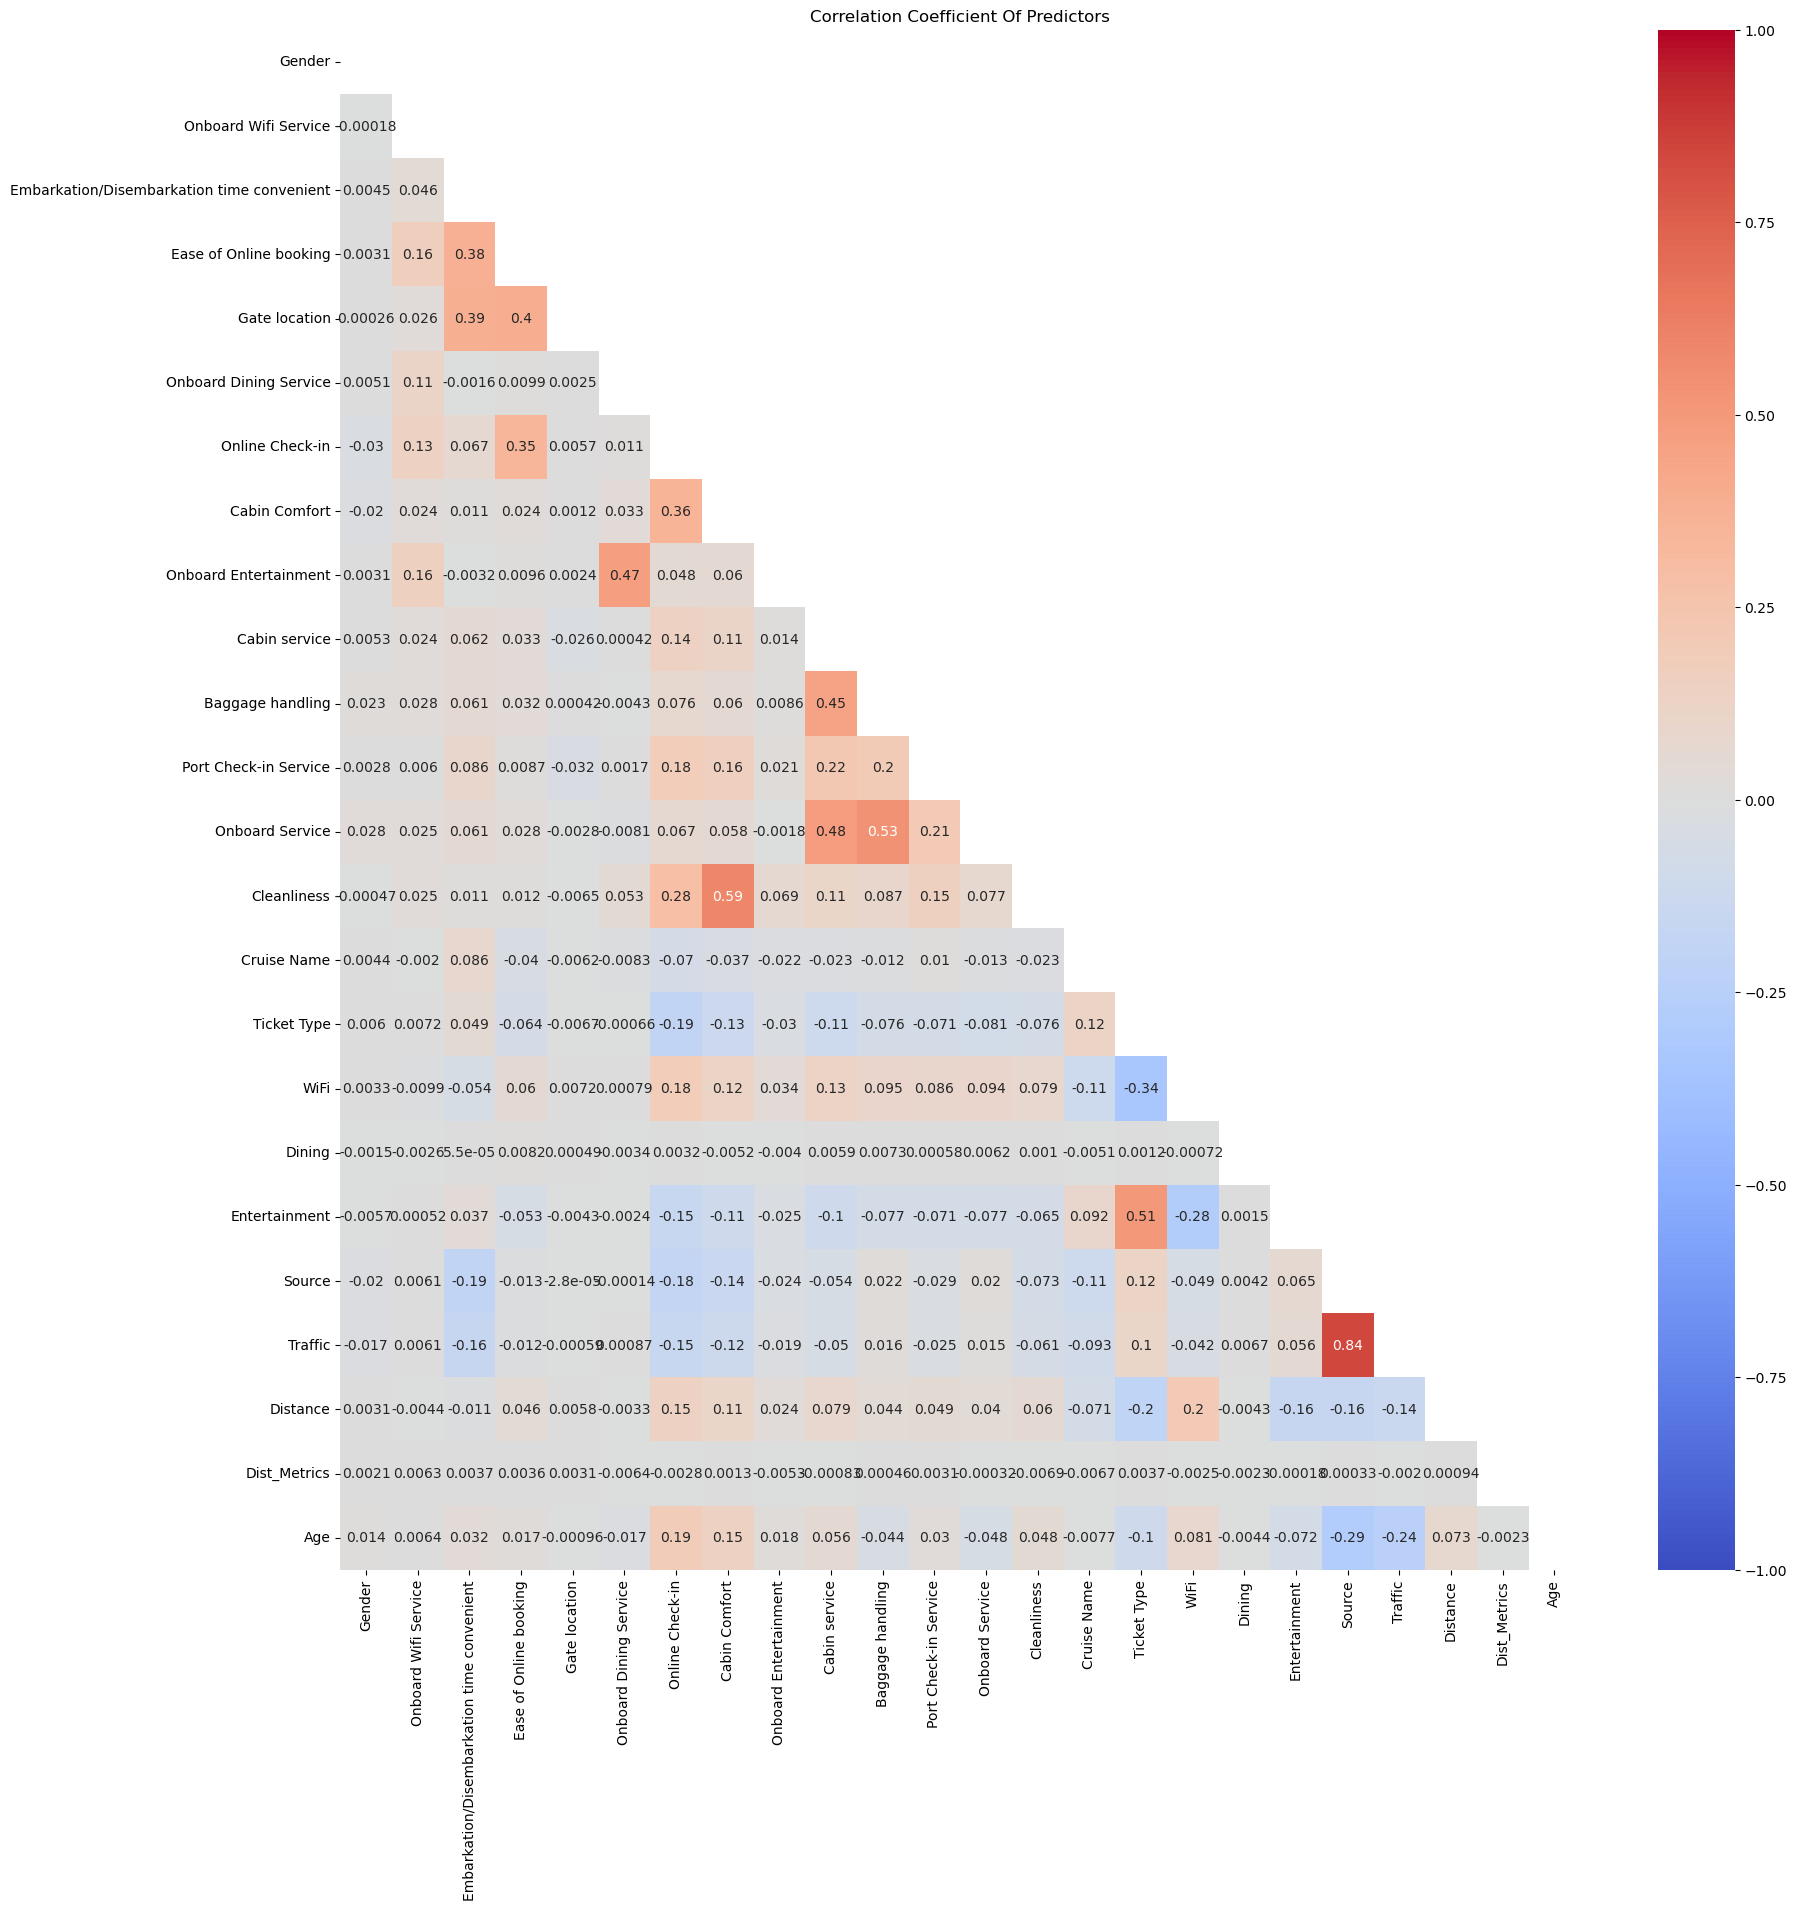

In [22]:
plot_corr_chart(df_cruise)

# Model Building

In [23]:
df_cruise.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84459 entries, 2 to 133745
Data columns (total 24 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Gender                                      84459 non-null  int32  
 1   Onboard Wifi Service                        84459 non-null  int32  
 2   Embarkation/Disembarkation time convenient  84459 non-null  float64
 3   Ease of Online booking                      84459 non-null  float64
 4   Gate location                               84459 non-null  float64
 5   Onboard Dining Service                      84459 non-null  int32  
 6   Online Check-in                             84459 non-null  float64
 7   Cabin Comfort                               84459 non-null  float64
 8   Onboard Entertainment                       84459 non-null  int32  
 9   Cabin service                               84459 non-null  float64
 10  Baggage handli

In [24]:
X = df_cruise.drop([TARGET_VARIABLE],axis=1)
y = df_cruise[TARGET_VARIABLE]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE , random_state=RANDOM_STATE)

In [25]:
# from imblearn.over_sampling import SMOTE


# os = SMOTE(random_state=RANDOM_STATE)
# columns = X.columns
# X_train, y_train = os.fit_resample(X_train, y_train)

In [26]:
df_cruise.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84459 entries, 2 to 133745
Data columns (total 24 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Gender                                      84459 non-null  int32  
 1   Onboard Wifi Service                        84459 non-null  int32  
 2   Embarkation/Disembarkation time convenient  84459 non-null  float64
 3   Ease of Online booking                      84459 non-null  float64
 4   Gate location                               84459 non-null  float64
 5   Onboard Dining Service                      84459 non-null  int32  
 6   Online Check-in                             84459 non-null  float64
 7   Cabin Comfort                               84459 non-null  float64
 8   Onboard Entertainment                       84459 non-null  int32  
 9   Cabin service                               84459 non-null  float64
 10  Baggage handli

In [27]:
log_regression = LogisticRegression(random_state=RANDOM_STATE, max_iter=5000)
log_regression.fit(X_train, y_train)
y_train_pred_log = log_regression.predict(X_train)
y_test_pred_log = log_regression.predict(X_test)

In [28]:
# random_forest = RandomForestClassifier()
# random_forest.fit(X_train, y_train)
# y_train_pred_rf = random_forest.predict(X_train)
# y_test_pred_rf = random_forest.predict(X_test)

# Model Evaluation

In [29]:
from sklearn import metrics
print("Classification report - Train")
print(classification_report(y_train, y_train_pred_log))
print(classification_report(y_test, y_test_pred_log))
print(" ")
print("Classification report - Test")
print(confusion_matrix(y_train, y_train_pred_log))
print("Confusion Matrix - Test")
print(confusion_matrix(y_test, y_test_pred_log))
print(" ")
print("Train Accuracy: ",format(metrics.accuracy_score(y_train, y_train_pred_log), '.4f'))
# print("Train Precision: ",format(metrics.precision_score(y_train, y_train_pred_log, average='micro'), '.4f'))
# print("Train Recall:",format(metrics.recall_score(y_train, y_train_pred_log,average='micro'), '.4f'))
# print(" ")
print("Test Accuracy:",format(metrics.accuracy_score(y_test, y_test_pred_log), '.4f'))
# print("Test Precision:",format(metrics.precision_score(y_test, y_test_pred_log,average='micro'), '.4f'))
# print("Test Recall:",format(metrics.recall_score(y_test, y_test_pred_log,average='micro'), '.4f'))

print("")


Classification report - Train
              precision    recall  f1-score   support

           0       0.51      0.13      0.21      4977
           1       0.91      0.83      0.87     32205
           2       0.81      0.97      0.88     30385

    accuracy                           0.85     67567
   macro avg       0.74      0.65      0.65     67567
weighted avg       0.83      0.85      0.83     67567

              precision    recall  f1-score   support

           0       0.51      0.14      0.22      1227
           1       0.91      0.84      0.87      8137
           2       0.80      0.97      0.88      7528

    accuracy                           0.85     16892
   macro avg       0.74      0.65      0.66     16892
weighted avg       0.84      0.85      0.83     16892

 
Classification report - Test
[[  670  1922  2385]
 [  636 26857  4712]
 [    0   807 29578]]
Confusion Matrix - Test
[[ 170  432  625]
 [ 164 6816 1157]
 [   0  206 7322]]
 
Train Accuracy:  0.8452
Test Acc